<a href="https://colab.research.google.com/github/StefanoBergia/Tesi_Anomaly_Detection/blob/main/UNSUPERVISED_ANOMALY_DETECTION_LSMT_AUTOENCODER_DAILY_DBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
!pip install tensorflow-gpu
import tensorflow as tf
from tensorflow import keras

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import widgets
from plotly.subplots import make_subplots
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
import matplotlib.colors as mcolors
import datetime
import time
import warnings

colors=mcolors.TABLEAU_COLORS
colormap=np.array(list(list(zip(*colors.items()))[1]))
colormap=np.concatenate((colormap, colormap[1:],colormap[1:]), axis=0)

RANDOM_SEED = 161297

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [ ]:

#################
min_date='2021-07-21 16:58:36'  ##########attenzione, ci sono tutti i lag
#################

max_date='2021-08-28 00:00:00'

drive.mount('/content/gdrive',force_remount=True)
df_original = pd.read_csv('/content/gdrive/MyDrive/Dati_Tesi/PIVOT_WLS_HVST_1_MONTH.csv', parse_dates=['TS'], index_col='TS')
df_original.index = pd.DatetimeIndex(df_original.index)
df_original=df_original.asfreq(freq='60s',method='ffill')
df=df_original.copy()
df=df.loc[min_date:max_date]

columns=df.columns.drop(['431','907']).drop(['436','480','482','777','781','783','910'])

###########
columns=['776']
params={
    '272':{'epoch':10,
            'ml':18,
            'th':0.001,
           'rw':0},
    '430':{'epoch':15,
            'ml':20,
            'th':0.004,
           'rw':0},
    '776':{'epoch':15,
            'ml':60,
            'th':0.001,
           'rw':0},
    '780':{'epoch':10,
            'ml':60,
            'th':0.005,
           'rw':0},
    '782':{'epoch':10,
            'ml':30,
            'th':0.0021,
           'rw':0},
    '784':{'epoch':15,
            'ml':60,
            'th':0.05,
           'rw':0},
    '908':{'epoch':5,
            'ml':30,
            'th':0.001,
           'rw':1},
    '909':{'epoch':6,
            'ml':60,
            'th':0.003,
           'rw':1},
}
##########

period_length=1440

print(columns)

Mounted at /content/gdrive
['776']


In [ ]:
first_two_weeks=df.loc['2021-07-24 00:00:00':'2021-08-06 23:59:00']
last_week=df.loc['2021-08-21 00:00:00': '2021-08-28 00:00:00']
strange_week=df.loc['2021-08-14 00:00:00': '2021-08-21 00:00:00']
remove_week=df.loc['2021-08-07 00:00:00':'2021-08-14 00:00:00']

available_lag=df.loc['2021-07-21 16:58:36':'2021-07-24 00:00:00']

strange_week=strange_week*1

last_week.index=strange_week.index
strange_week.index=remove_week.index

df=pd.concat([first_two_weeks, strange_week,last_week])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

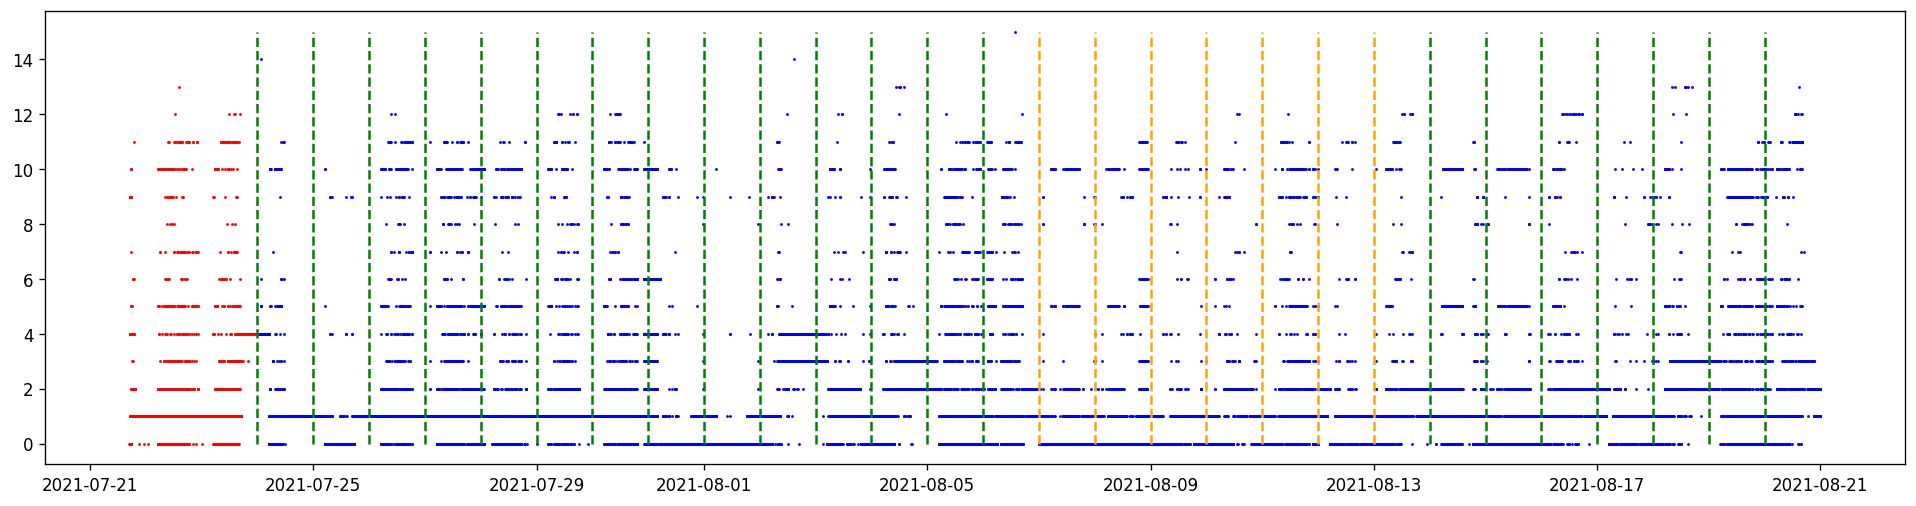

<IPython.core.display.Javascript object>

In [ ]:
tb = widgets.TabBar([columns[i] for i in range(len(columns))])

midnights = np.array([])
colors=np.array([])
count=0
for i in range(0,len(df.index),period_length):
  midnights=np.append(midnights,df.index[i])
  if count <14 or count >=28:
    colors=np.append(colors,'green')
  else:
    if count >= 14 and count <21:
      colors=np.append(colors,'orange')
  count=count+1


for col in columns:
  with tb.output_to(col):
    plt.rcParams.update({'figure.figsize': (25, 10), 'figure.dpi': 120})
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.scatter(x=df.index, y=df[col], color='blue',s=0.5)
    ax.scatter(x=available_lag.index, y=available_lag[col], color='red',s=0.5)
    ax.vlines(midnights, df[col].min(), df[col].max(), linestyles='dashed', colors=colors)
    fig.show();

In [ ]:
TIME_STEPS = 60

lag=available_lag[-TIME_STEPS:]
df_lagged=pd.concat([lag,df])


#train=df_lagged.loc[df_lagged.index[0]:'2021-08-14 00:00:00']
train=df_lagged.loc[df_lagged.index[0]:'2021-08-21 00:00:00']

#test=df_lagged.loc[datetime.datetime(2021, 8, 14, 0, 0, 0)-datetime.timedelta(minutes=TIME_STEPS):'2021-08-21 00:00:00']



print("dataset")
print(df.shape)
print(df.index[0],df.index[-1])
print ("lag")
print(lag.shape)
print(lag.index[0],lag.index[-1])
print("dataset lagged")
print(df_lagged.shape)
print(df_lagged.index[0],df_lagged.index[-1])
print("train")
print(train.shape)
print(train.index[0],train.index[-1])
#print("test")
#print( test.shape)
#print(test.index[0],test.index[-1])

dataset
(40319, 17)
2021-07-24 00:00:36 2021-08-20 23:59:36
lag
(60, 17)
2021-07-23 23:00:36 2021-07-23 23:59:36
dataset lagged
(40379, 17)
2021-07-23 23:00:36 2021-08-20 23:59:36
train
(40379, 17)
2021-07-23 23:00:36 2021-08-20 23:59:36


In [ ]:
scaler = MinMaxScaler()


#plt.scatter(x=train.index , y=train[columns[0]],color='orange',s=1)
#plt.show()
if col=='784':
  print("?")
else:
  with warnings.catch_warnings():
      warnings.filterwarnings("ignore")
      scaler = scaler.fit(train[[col]])
      train[col] = scaler.transform(train[[col]])
      #test[col] = scaler.transform(test[[col]])
#plt.scatter(x=train.index , y=train[columns[0]],color='orange',s=1)
#plt.show()

In [ ]:
def create_lagged_dataset(dataset, steps):
    X_lagged= []
    index_lagged=[]
    Y_lagged= []
    for i in range(len(dataset.index) - steps):

        lag = dataset.iloc[i :(i + steps)].values
        X_lagged.append(lag)

        index_lag=dataset.index[i :(i + steps)]
        index_lagged.append(index_lag)

        Y_lagged.append(dataset.iloc[i+steps])
    X_lagged= np.array(X_lagged)
    X_lagged= X_lagged.reshape(X_lagged.shape[0],X_lagged.shape[1],1)
    index_lagged= np.array(index_lagged)
    index_lagged=index_lagged.reshape(index_lagged.shape[0],index_lagged.shape[1],1)
    Y_lagged= np.array(Y_lagged)
    Y_lagged=Y_lagged.reshape(Y_lagged.shape[0],1)
    return  X_lagged,index_lagged, Y_lagged

In [ ]:
# X_train [n, time_steps, 1]
X_train,index_train, Y_train,= create_lagged_dataset(train[col], TIME_STEPS)
#X_test,index_test,Y_test= create_lagged_dataset(test[col], TIME_STEPS)

#print(X_train.shape,index_train.shape,Y_train.shape)
#print(X_test.shape,index_test.shape,Y_test.shape)

model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 60, 64)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 64)            33024     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 64)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 60, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [ ]:
fitted_model = model.fit(
    X_train, Y_train,
    epochs=params[columns[0]]['epoch'],
    batch_size=64,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/15
567/567 [==============================] - 61s 102ms/step - loss: 0.0718 - val_loss: 0.1085
Epoch 2/15
567/567 [==============================] - 58s 103ms/step - loss: 0.0648 - val_loss: 0.1108
Epoch 3/15
567/567 [==============================] - 59s 103ms/step - loss: 0.0639 - val_loss: 0.1081
Epoch 4/15
567/567 [==============================] - 60s 105ms/step - loss: 0.0631 - val_loss: 0.1056
Epoch 5/15
567/567 [==============================] - 59s 104ms/step - loss: 0.0623 - val_loss: 0.1016
Epoch 6/15
567/567 [==============================] - 59s 104ms/step - loss: 0.0618 - val_loss: 0.1001
Epoch 7/15
567/567 [==============================] - 59s 103ms/step - loss: 0.0617 - val_loss: 0.0993
Epoch 8/15
567/567 [==============================] - 57s 100ms/step - loss: 0.0615 - val_loss: 0.0983
Epoch 9/15
567/567 [==============================] - 57s 100ms/step - loss: 0.0613 - val_loss: 0.0982
Epoch 10/15
567/567 [==============================] - 56s 98ms/step - lo

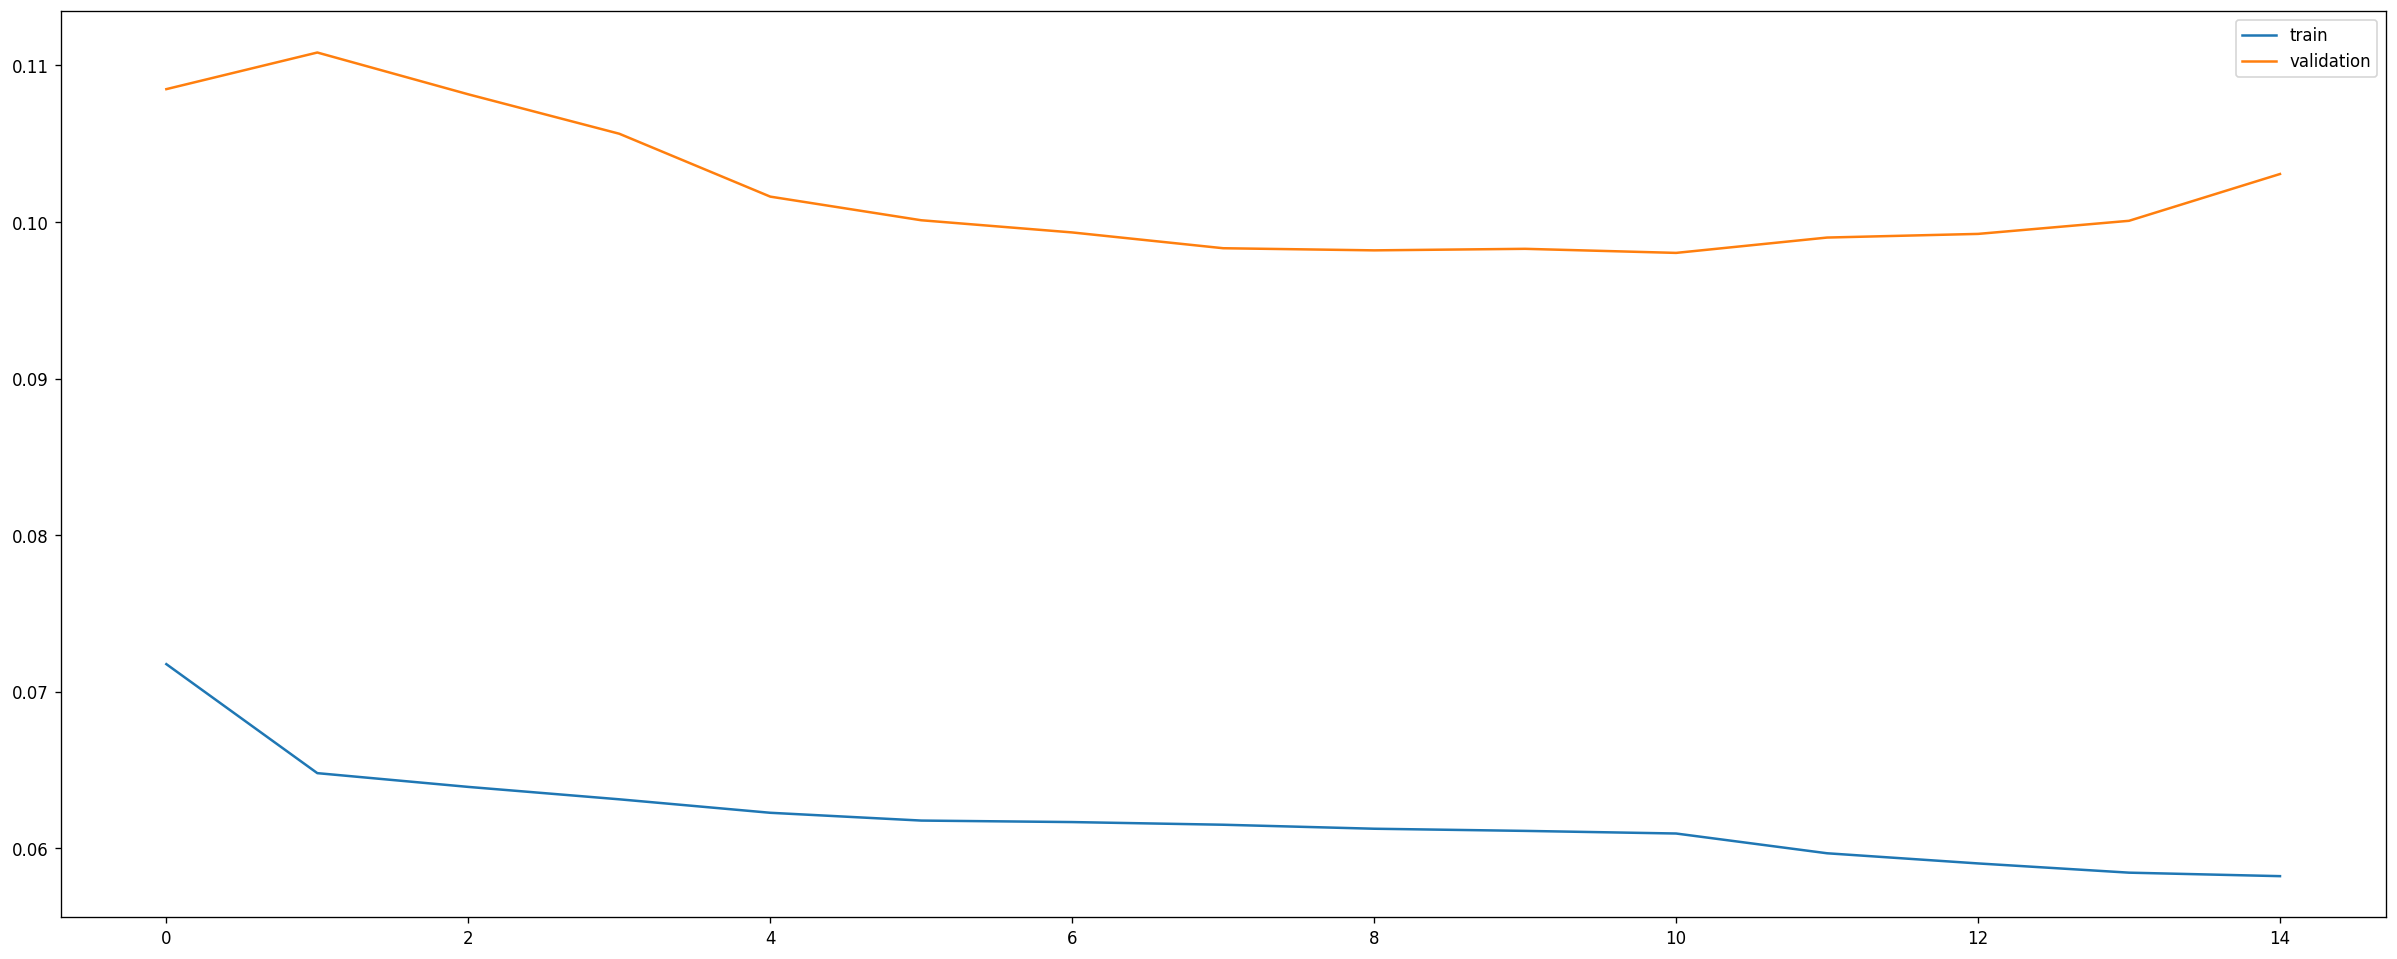

In [ ]:

plt.plot(fitted_model.history['loss'], label='train')
plt.plot(fitted_model.history['val_loss'], label='validation')
plt.legend();

# RISULTATI TRAINING

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
#print(X_train_pred)

In [ ]:
#THRESHOLD = 0.09

train_score_df = pd.DataFrame(index=train[TIME_STEPS:].index)
train_score_df['loss'] = train_mae_loss
#train_score_df['threshold'] = THRESHOLD
#train_score_df['anomaly'] = train_score_df.loss > train_score_df.threshold
train_score_df['value'] = train[TIME_STEPS:][columns[0]]

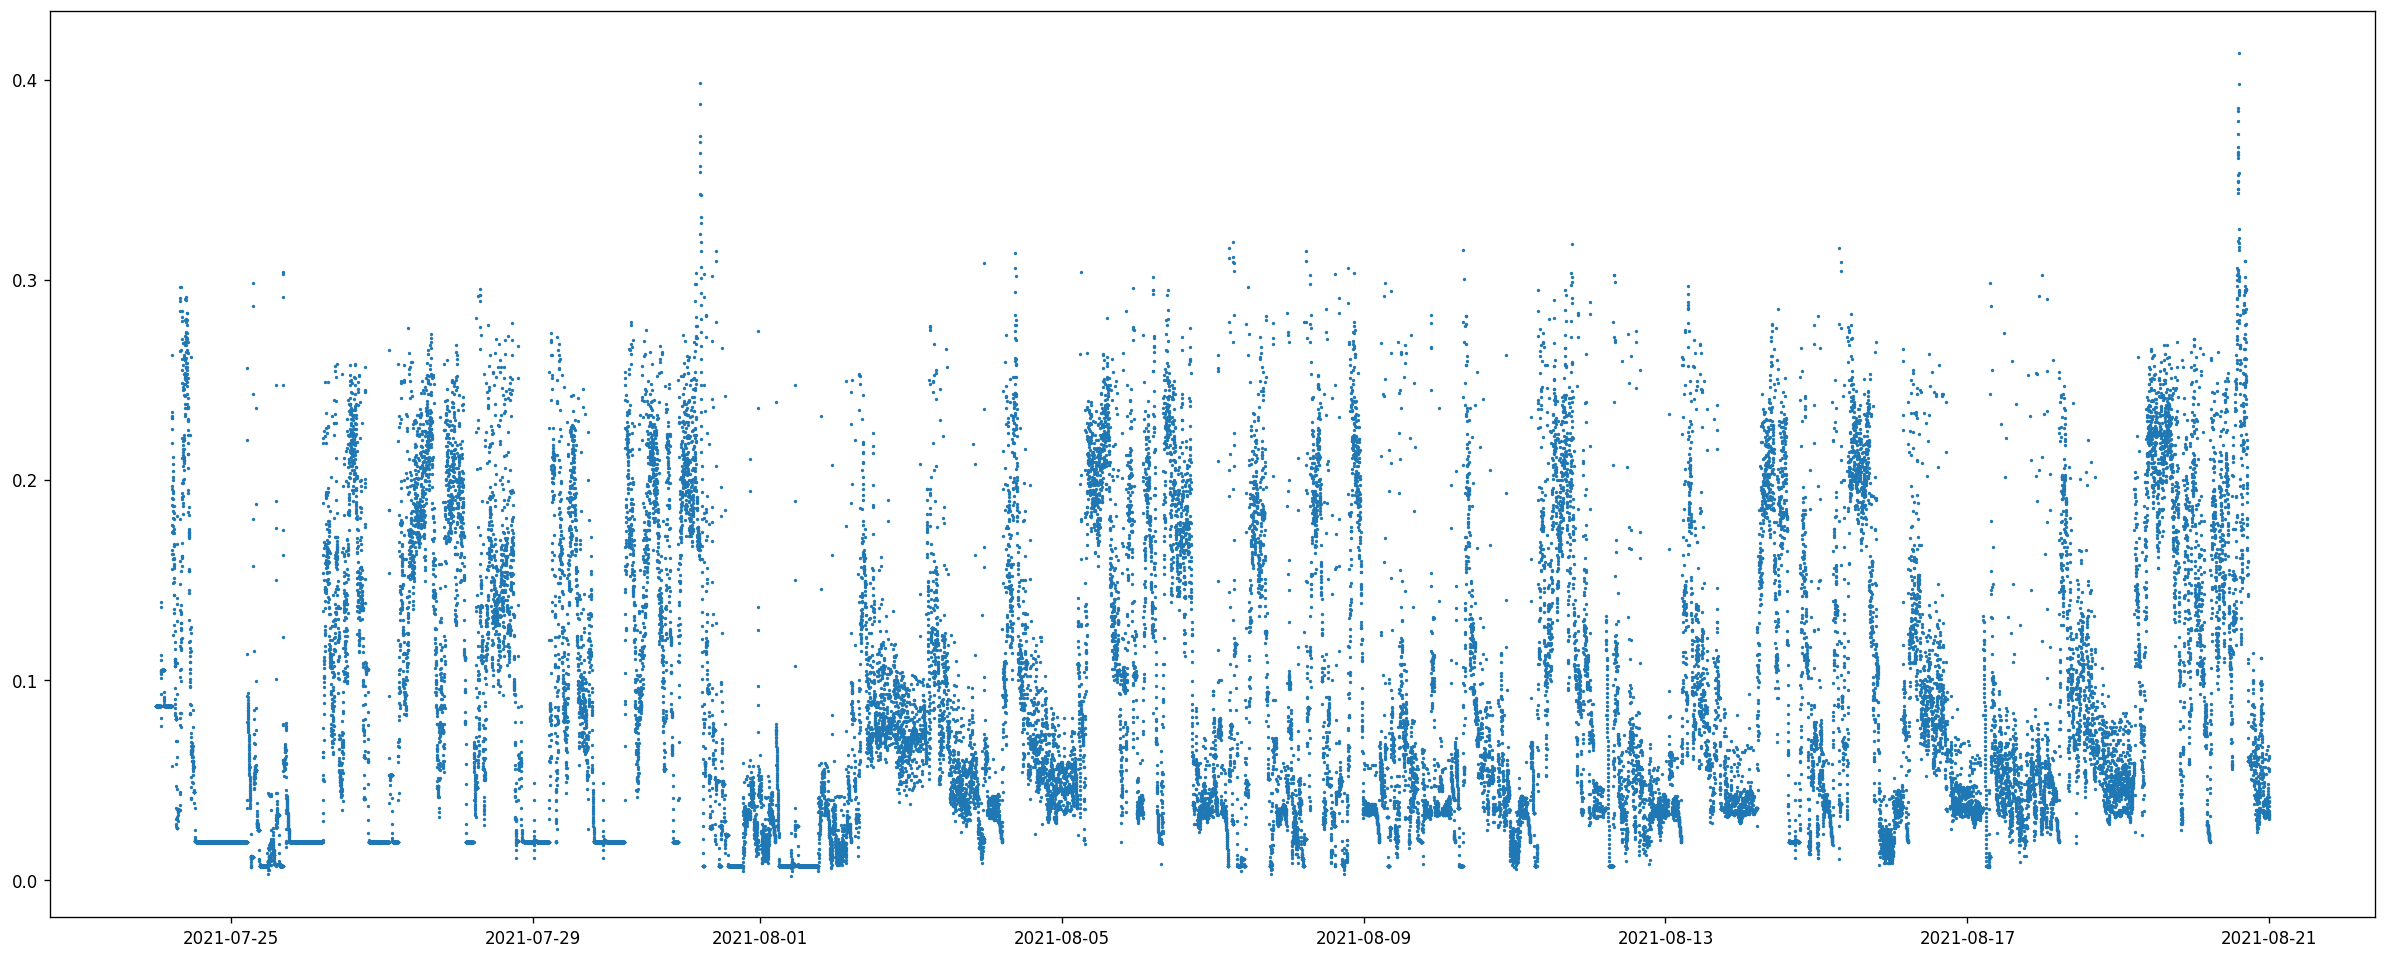

2021-07-30T05:03:36.000000000 2021-07-30T20:21:36.000000000
2021-07-30T22:06:36.000000000 2021-07-30T23:59:36.000000000


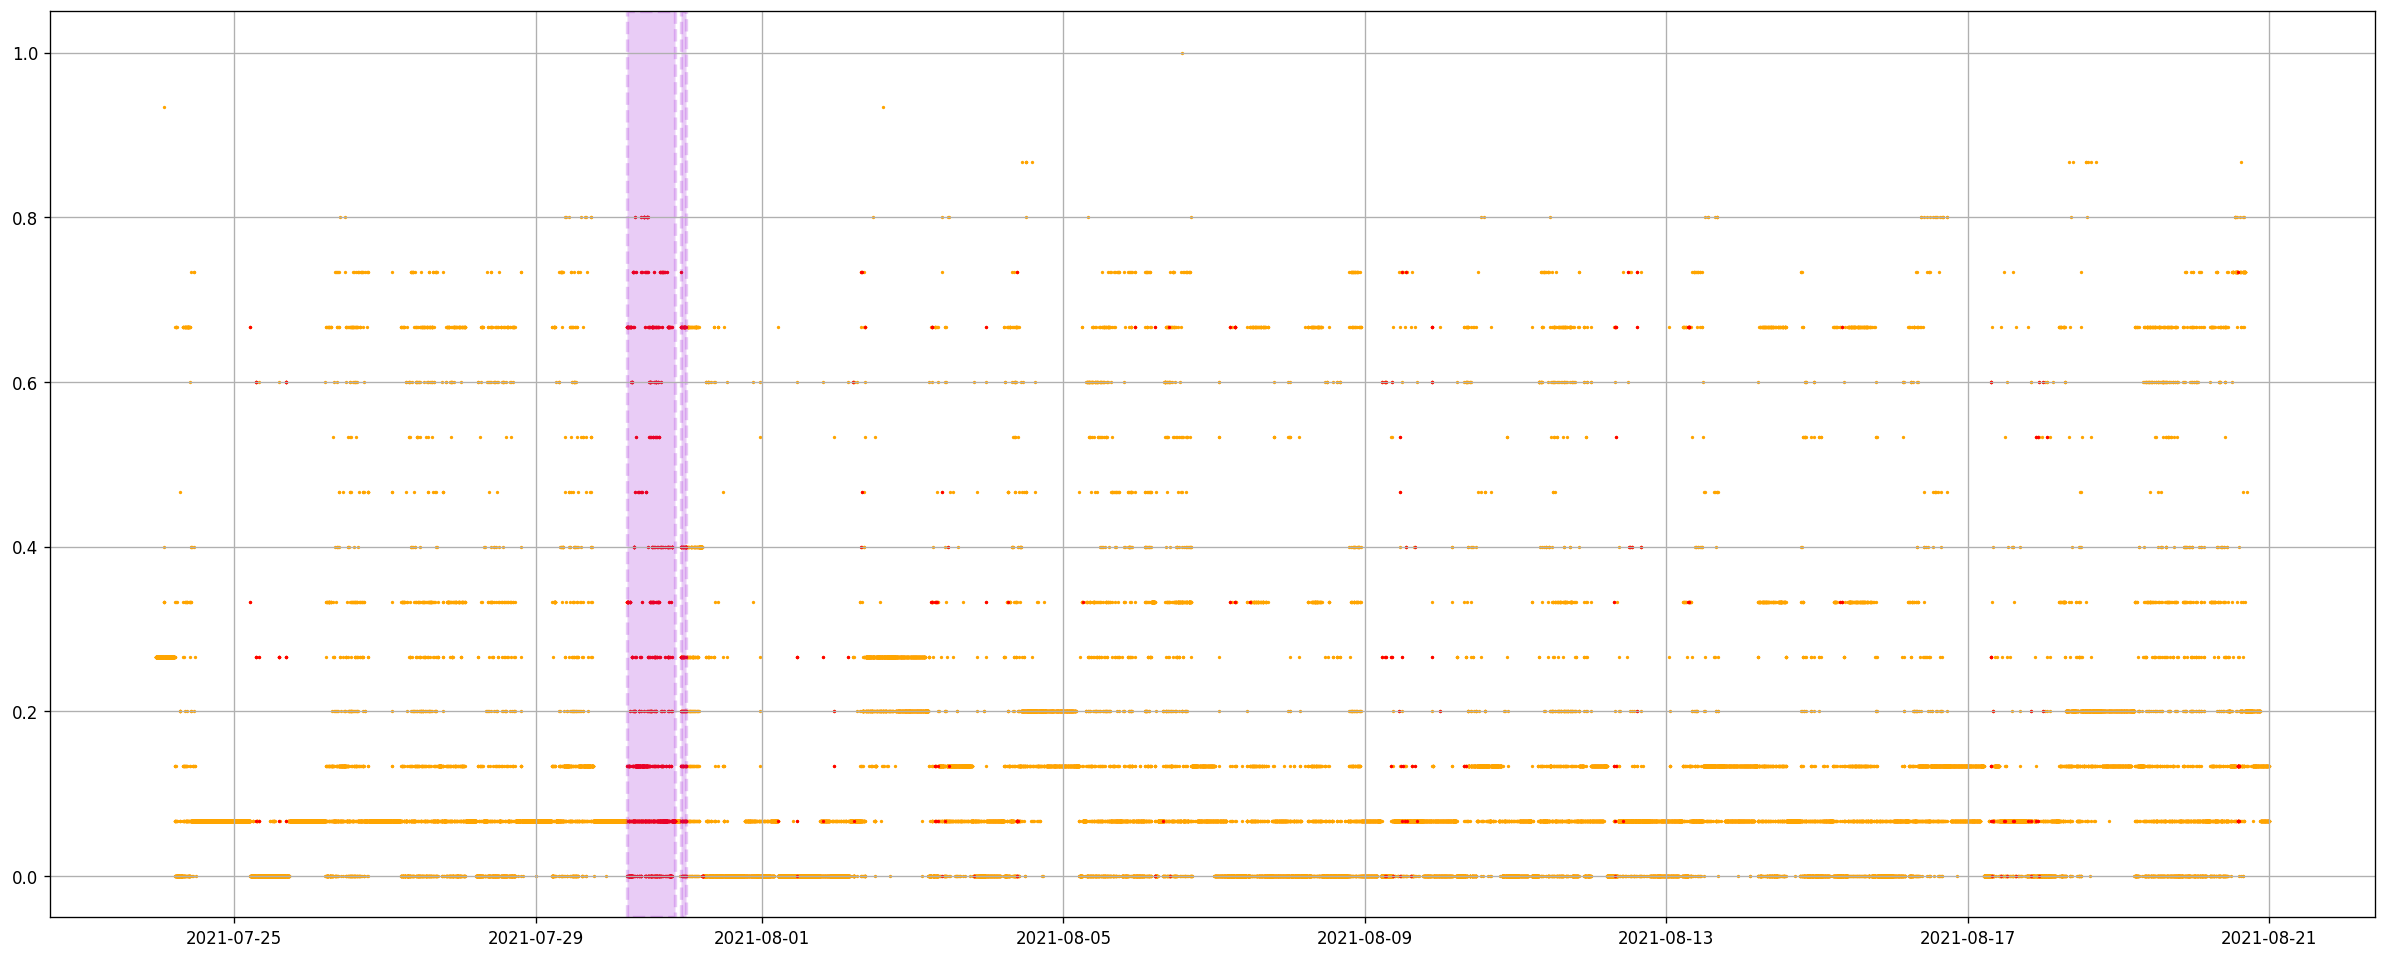

In [ ]:
from sklearn.cluster import DBSCAN
import datetime

plt.scatter(x=train_score_df['loss'].index,y=train_score_df['loss'],s=1)
plt.show()
#min_lenght=params[columns[0]]['ml']
min_lenght=30
plt.scatter(x=train.index , y=train[columns[0]],color='orange',s=1)
anomalies_intervals=np.array([])
###################
for i in range(0,len(train_score_df['loss']),period_length):
  cur_df=train_score_df['loss'].iloc[i:i+period_length]

  sorted_df=cur_df.sort_values()
  s_low=sorted_df.iloc[:-1].values
  s_up=sorted_df.iloc[1:].values
  s_diff=abs(s_up-s_low)
  #s_diff=s_diff[(s_diff >= params[columns[0]]['th'])]#0.0005
  s_diff=s_diff[(s_diff >= 0.005)]

  if len(s_diff>0):
    avg_density=s_diff.mean()
    clustering = DBSCAN(eps=avg_density, min_samples=1).fit(cur_df.to_numpy().reshape(-1, 1))    #DBSCAN
    labels=np.array(clustering.labels_)

    labels_df=pd.DataFrame(labels)
    labels_df.index=pd.DatetimeIndex(cur_df.index)
    anomalies_df=labels_df[labels_df > 0].dropna()

    #print(anomalies_df.index.values)
    flag=1
    write_last=0

    if(len(anomalies_df.index)>0):
      date_low=anomalies_df.index.values[0]

    for date in anomalies_df.index.values[1:]:
      if flag==1:
        date_high=date
        flag=0
        if (pd.Timedelta((date_high-date_low)).total_seconds()>60):
          date_low=date_high
          flag=1
        
      else:
        if  pd.Timedelta((date-date_high)).total_seconds()<=60:
          date_high=date
          write_last=1
        else:
          if pd.Timedelta((date_high-date_low)).total_seconds()>=60*min_lenght:
            dl=pd.to_datetime(date_low)
            dh= pd.to_datetime(date_low)
            if  params[columns[0]]['rw']==0 or dl.isoweekday()<6  :
              plt.axvspan(date_low, date_high, alpha=0.2, color='darkviolet',linewidth=2,linestyle='dashed')
              print(date_low, date_high)
          date_low=date
          flag=1
    if  write_last==1 and pd.Timedelta((date_high-date_low)).total_seconds()>=60*min_lenght:
        dl=pd.to_datetime(date_low)
        dh= pd.to_datetime(date_low)
        if  params[columns[0]]['rw']==0 or dl.isoweekday()<6  :
          plt.axvspan(date_low, date_high, alpha=0.2, color='darkviolet',linewidth=2,linestyle='dashed')
          print(date_low, date_high)


    plt.scatter(x=anomalies_df.index , y=train[columns[0]].loc[anomalies_df.index],color='red',s=1)

plt.grid();
plt.show();
###################
